In [1]:
import pandas as pd
import numpy as np
import pm4py
from variant_stats import get_variants_stats
from pm4py.util import ml_utils
import importlib.util
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from sklearn.cluster import SpectralClustering

In [2]:
df2 = pd.read_pickle('decision_paths/subset_optimized_simple_size_0.2_fitnessweights_p0.34_f0.33_c0.33_weightmodel_weight_positive_simplified.pickle')

# Initialize an empty list to hold event log rows
event_log0 = []
event_log1 = []

# Iterate over each decision path in the dataset
timestamp = pd.Timestamp('2024-11-14')
case_id = -1
for i in range(len(df2)):
    data = df2['rule_to_simplified_rules'].iloc[i]
    for path in data:
        case_id += 1
        for t,step in enumerate(path):
            # Create an event dictionary for the current step
            event = {
                'case_id': case_id,
                'activity': step.get('feature_value'),
                'timestamp': timestamp + pd.Timedelta(days=t)
            }
            # if event['activity'] in to_remove:
            #     # print(f" I removed {event['activity']} from the log")
            #     continue
            if pd.isna(event['activity']):
                event['activity'] = f'predict{step['predict']}'

            
            # Append the event to the event log
            if path[-1]['predict'] == 1:
                event_log1.append(event)
            else:
                event_log0.append(event)

event_log1 = pd.DataFrame(event_log1)
event_log0 = pd.DataFrame(event_log0)
log1 = event_log1.copy()
log1.rename(columns={'timestamp': 'time:timestamp', 'case_id': 'case:concept:name', 'activity': 'concept:name'}, inplace=True)

log0 = event_log0.copy()
log0.rename(columns={'timestamp': 'time:timestamp', 'case_id': 'case:concept:name', 'activity': 'concept:name'}, inplace=True)

df0 = get_variants_stats(log0)
df1 = get_variants_stats(log1)

In [3]:
df1['sequence']

0       (functstat_90% -minor sx, rpvd_No, vintage_4.2...
1       (functstat_20% -very sick, dhtn2_Yes-hypertens...
2       (functstat_20% -very sick, dhtn2_Yes-hypertens...
3       (functstat_20% -very sick, dhtn2_Yes-hypertens...
4       (functstat_30% -severely disabled, dhtn2_Yes-h...
                              ...                        
1331    (functstat_50% -req consid assist, dhtn2_Yes-h...
1332    (functstat_50% -req consid assist, dhtn2_Yes-h...
1333    (functstat_40% -disabled, dhtn2_Yes-hypertensi...
1334    (functstat_40% -disabled, dhtn2_Yes-hypertensi...
1335    (functstat_40% -disabled, dhtn2_Yes-hypertensi...
Name: sequence, Length: 1336, dtype: object

In [4]:
trace_strings = [' '.join(trace) for trace in df1['sequence']]

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Apply TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(trace_strings)  # X is a matrix (n_traces x n_activities)

# Check the shape and feature names
print("TF-IDF Matrix shape:", X.shape)
print("Feature names:", vectorizer.get_feature_names_out())

TF-IDF Matrix shape: (1336, 166)
Feature names: ['12' '14' '146' '154' '162' '165' '17' '170' '177' '178' '18' '203' '21'
 '210' '23' '24' '25' '26' '29' '34' '35' '38' '49' '56' '64' '66' '67'
 '68' '69' '71' '77' '79' '82' '83' '84' '88' '90' '92' '99' 'abo_a'
 'abo_a1' 'abo_a1b' 'abo_a2' 'abo_a2b' 'abo_ab' 'abo_b' 'abo_o' 'activity'
 'albumin_2' 'albumin_3' 'albumin_4' 'assist' 'assistance' 'cad' 'can'
 'cats_0' 'cats_12' 'cats_17' 'cats_23' 'cit' 'cod_anoxia'
 'cod_cerebrovascular' 'cod_cns' 'complaints' 'consid' 'creat_0' 'creat_4'
 'creat_7' 'dage_22' 'dage_35' 'dage_5' 'dage_65' 'dbmisimp_' 'dcd_no'
 'dht100_126' 'dht100_165' 'dht100_170' 'dht100_178' 'dhtn2_no'
 'dhtn2_yes' 'disabled' 'dm' 'do' 'don' 'doncreat_0' 'doncreat_1'
 'dsex_female' 'dsex_male' 'dwt_79' 'dwt_92' 'ecd_0' 'ecd_1'
 'esrddxsimp_diabetes' 'esrddxsimp_gn' 'esrddxsimp_htn' 'esrddxsimp_other'
 'esrddxsimp_pckd' 'functstat_10' 'functstat_100' 'functstat_20'
 'functstat_30' 'functstat_40' 'functstat_50' 'functsta

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:42<00:00,  1.51s/it]


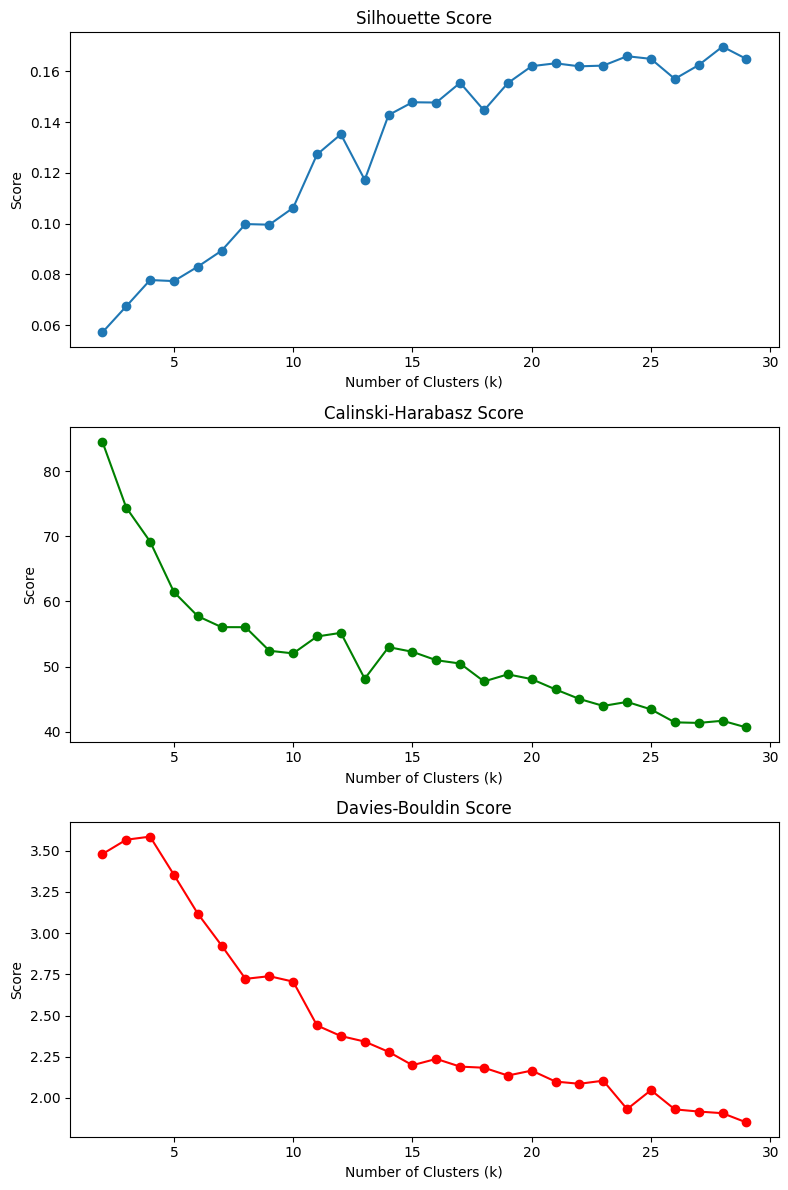

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Store scores for different cluster numbers
k_values = range(2, 30)  # Up to len(traces)-1
silhouette_scores = []
calinski_scores = []
davies_scores = []

# Run KMeans and calculate clustering scores
for k in tqdm(k_values):
    clustering = SpectralClustering(n_clusters=k, assign_labels='discretize', random_state=0).fit(X)
    labels = clustering.labels_
    # kmeans = KMeans(n_clusters=k, random_state=42)
    # labels = kmeans.fit_predict(X)

    silhouette_scores.append(silhouette_score(X, labels))
    calinski_scores.append(calinski_harabasz_score(X.toarray(), labels))
    davies_scores.append(davies_bouldin_score(X.toarray(), labels))

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Silhouette Score
axs[0].plot(k_values, silhouette_scores, marker='o')
axs[0].set_title("Silhouette Score")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Score")

# Calinski-Harabasz Index
axs[1].plot(k_values, calinski_scores, marker='o', color='green')
axs[1].set_title("Calinski-Harabasz Score")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("Score")

# Davies-Bouldin Index (lower is better)
axs[2].plot(k_values, davies_scores, marker='o', color='red')
axs[2].set_title("Davies-Bouldin Score")
axs[2].set_xlabel("Number of Clusters (k)")
axs[2].set_ylabel("Score")

plt.tight_layout()
plt.show()


In [7]:
kmeans = SpectralClustering(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(X)

In [8]:
from pm4py.objects.log.obj import EventLog, Trace
from datetime import datetime, timedelta

sequences = df1.iloc[labels==9]['sequence']

# Create an empty event log
event_log = EventLog()

# Define base timestamp
base_time = datetime(2024, 1, 1, 0, 0, 0)

# Loop through each sequence
for idx, sequence in enumerate(sequences):
    trace = Trace()
    case_id = f"Case_{idx+1}"
    
    for i, activity in enumerate(sequence):
        event = {
            "case:concept:name": case_id,
            "concept:name": activity,
            "time:timestamp": base_time + timedelta(minutes=i)
        }
        trace.append(event)
    
    event_log.append(trace)
execute_script(event_log)

NameError: name 'execute_script' is not defined

In [ ]:
numbers = {}
for i in range(len(np.unique(labels))):
    sequences = df1.iloc[labels==i]['sequence']
    print(f'cluster {i} has {len(sequences)}')
    numbers[i] = len(sequences)

In [46]:
sorted_dict = dict(sorted(numbers.items(), key=lambda item: item[1]))
sorted_dict

{5: 62, 2: 83, 6: 86, 7: 94, 4: 100, 9: 121, 8: 139, 1: 180, 3: 228, 0: 243}

In [54]:
from collections import Counter

sequences = df1.iloc[labels==9]['sequence']
flattened = [item for seq in sequences for item in seq]

# Count occurrences using Counter
count_dict = Counter(flattened)

# Sort the dictionary by value in descending order
sorted_dict = dict(sorted(count_dict.items(), key=lambda x: x[1], reverse=True))

# Print the result
print(sorted_dict)

{'predict1': 121, 'dhtn2_Yes-hypertension': 116, 'preemptive_No': 116, 'rdm2_Diabetes': 116, 'esrddxsimp_Diabetes': 97, 'ragetx_66.0-69.0': 49, 'rht100_162.56-170.18': 49, 'CAN-TOT-ALBUMIN_2.8-3.7': 49, 'rht100_170.18-177.8': 42, 'ragetx_71.0-83.0': 37, 'CAN-TOT-ALBUMIN_4.1-5.0': 37, 'functstat_80% -some sx': 36, 'CAN-TOT-ALBUMIN_3.7-3.88': 35, 'ragetx_69.0-71.0': 35, 'functstat_70% -unable to do normal activity': 31, 'rht100_177.8-210.82': 30, 'functstat_60% -req assistance': 29, 'functstat_50% -req consid assist': 13, 'esrddxsimp_GN': 8, 'esrddxsimp_Other': 7, 'functstat_40% -disabled': 7, 'rpvd_No': 5, 'vintage_4.25-14.83': 5, 'cit-cats_17-23': 5, 'pkpragroup_1': 5, 'esrddxsimp_PCKD': 4, 'functstat_20% -very sick': 3, 'dage_35-64': 3, 'functstat_30% -severely disabled': 1, 'dage_65-84': 1, 'dage_22-34': 1, 'functstat_90% -minor sx': 1}


In [55]:
sequences[0]

KeyError: 0

In [36]:
sorted_dict = dict(sorted(numbers.items(), key=lambda item: item[1]))

In [37]:
sorted_dict

{9: 26,
 19: 29,
 11: 42,
 16: 46,
 10: 53,
 4: 55,
 8: 55,
 0: 61,
 2: 62,
 14: 63,
 3: 66,
 17: 67,
 18: 68,
 15: 73,
 13: 76,
 6: 79,
 7: 84,
 5: 86,
 12: 122,
 1: 123}

In [11]:
sequences = df1.iloc[labels==2]['sequence']
len(sequences)

83

In [12]:
from pm4py.objects.log.obj import EventLog, Trace
from datetime import datetime, timedelta

# Create an empty event log
event_log = EventLog()

# Define base timestamp
base_time = datetime(2024, 1, 1, 0, 0, 0)

# Loop through each sequence
for idx, sequence in enumerate(sequences):
    trace = Trace()
    case_id = f"Case_{idx+1}"
    
    for i, activity in enumerate(sequence):
        event = {
            "case:concept:name": case_id,
            "concept:name": activity,
            "time:timestamp": base_time + timedelta(minutes=i)
        }
        trace.append(event)
    
    event_log.append(trace)


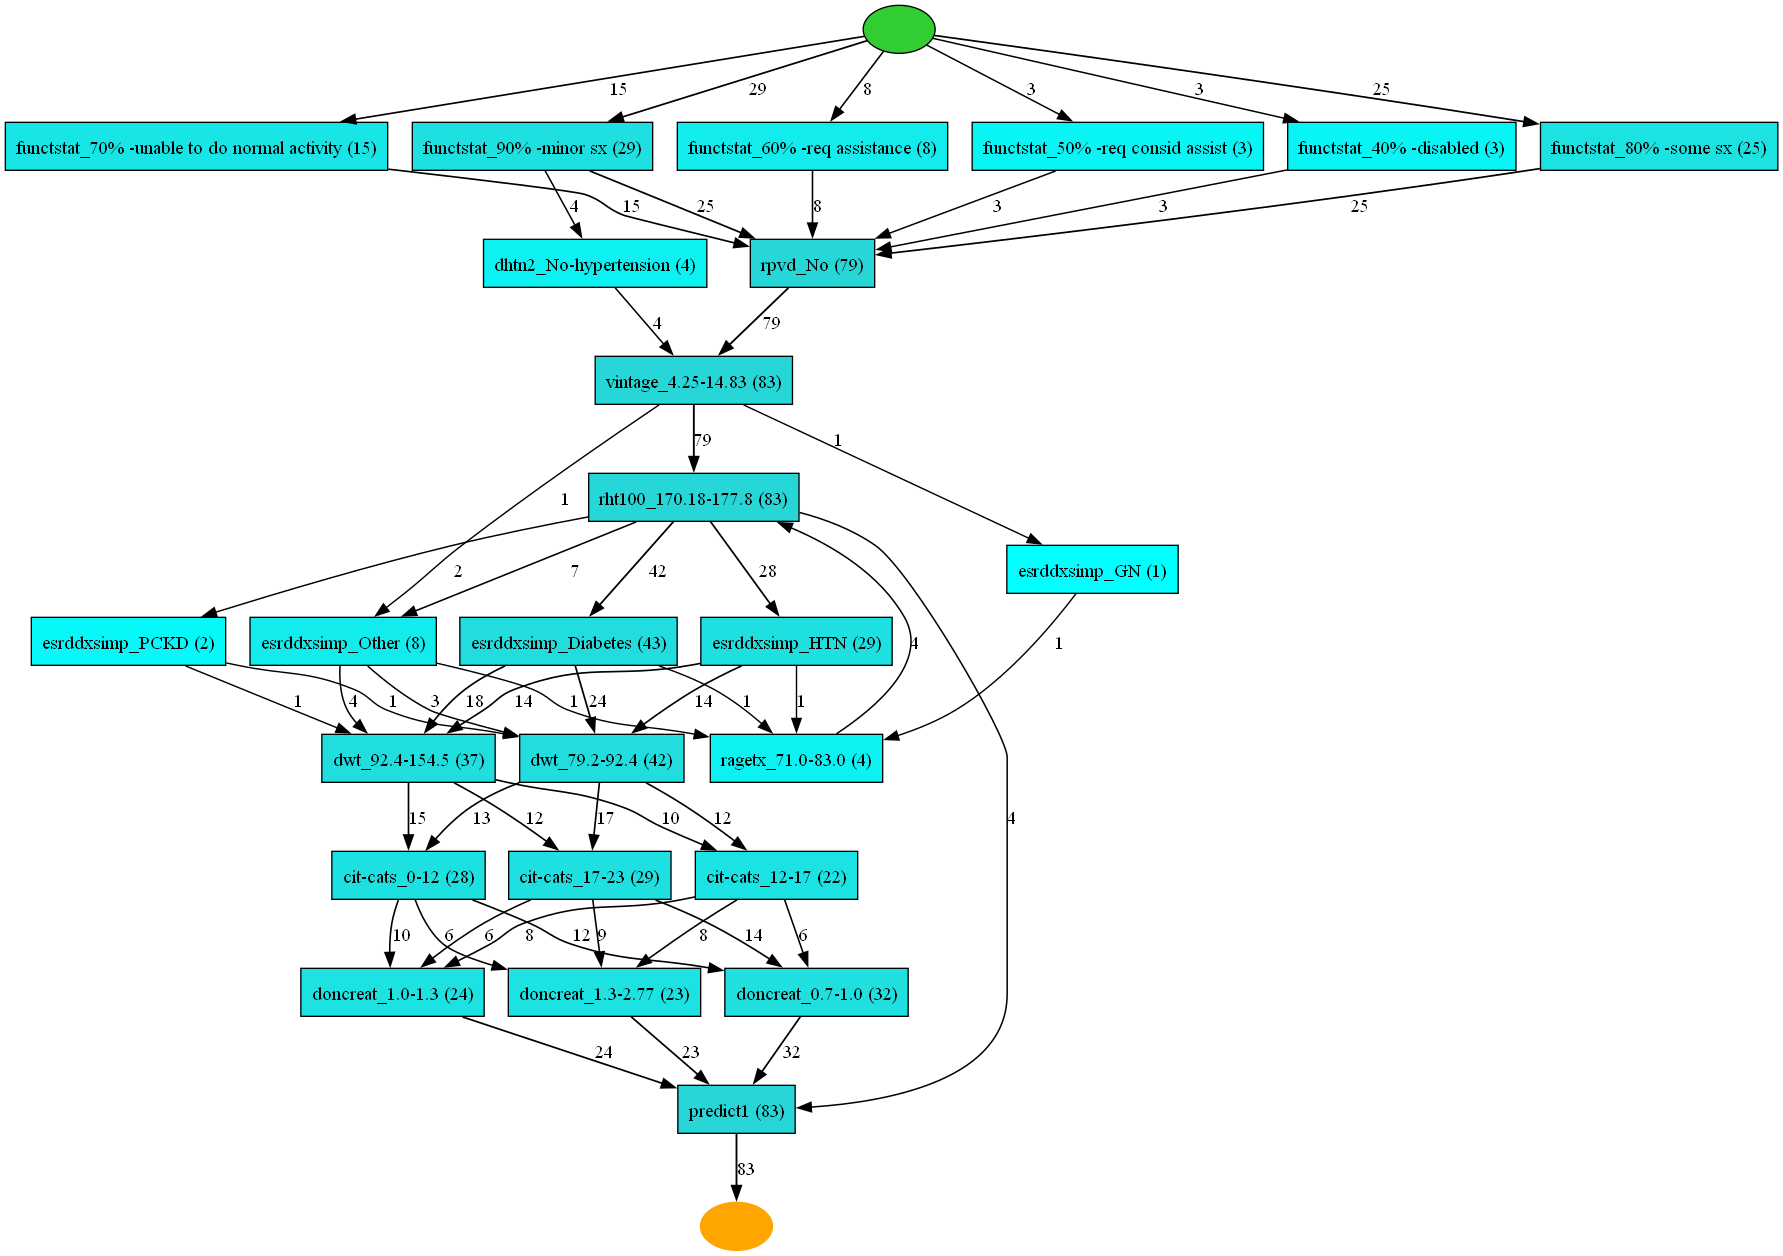

In [13]:
heu_net = heuristics_miner.apply_heu(event_log)

# visualize
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

In [12]:
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.exporter.xes import exporter as xes_exporter

# Assuming 'df' is your pandas DataFrame with at least:
# 'case:concept:name' (case ID), 'concept:name' (activity), 'time:timestamp' (timestamp)
parameters = {
    log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'
}

log = log_converter.apply(event_log, variant=log_converter.Variants.TO_EVENT_LOG, parameters=parameters)
xes_exporter.apply(log, 'cluster8.xes')


exporting log, completed traces ::   0%|          | 0/43 [00:00<?, ?it/s]

In [56]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation import algorithm as general_evaluation
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.process_tree import converter as process_tree_converter
def execute_script(log):
    process_tree = inductive_miner.apply(log)
    net, marking, final_marking = process_tree_converter.apply(process_tree)
    metrics = general_evaluation.apply(log, net, marking, final_marking)
    print("metrics=", metrics)

In [62]:
for i in range(10):

    sequences = df1.iloc[labels==i]['sequence']
    print(f"label - > {i}*****{i}")
    
    # Create an empty event log
    event_log = EventLog()
    
    # Define base timestamp
    base_time = datetime(2024, 1, 1, 0, 0, 0)
    
    # Loop through each sequence
    for idx, sequence in enumerate(sequences):
        trace = Trace()
        case_id = f"Case_{idx+1}"
        
        for i, activity in enumerate(sequence):
            event = {
                "case:concept:name": case_id,
                "concept:name": activity,
                "time:timestamp": base_time + timedelta(minutes=i)
            }
            trace.append(event)
        
        event_log.append(trace)
    execute_script(event_log)

label - > 0*****0


replaying log with TBR, completed traces ::   0%|          | 0/243 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/691 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.09087238644556594, 'generalization': 0.7224157599495552, 'simplicity': 0.5339233038348082, 'metricsAverageWeight': 0.5868028625574823, 'fscore': 0.16660498070110505}
label - > 1*****1


replaying log with TBR, completed traces ::   0%|          | 0/180 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/386 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.07086098906235394, 'generalization': 0.7083209133548423, 'simplicity': 0.559493670886076, 'metricsAverageWeight': 0.5846688933258181, 'fscore': 0.132343954604976}
label - > 2*****2


replaying log with TBR, completed traces ::   0%|          | 0/83 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/212 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.5224265892223298, 'generalization': 0.6951094244338722, 'simplicity': 0.5670103092783505, 'metricsAverageWeight': 0.6961365807336382, 'fscore': 0.6863077575243747}
label - > 3*****3


replaying log with TBR, completed traces ::   0%|          | 0/228 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/555 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.09374433363553947, 'generalization': 0.7046034757244206, 'simplicity': 0.5333333333333333, 'metricsAverageWeight': 0.5829202856733233, 'fscore': 0.17141909814323614}
label - > 4*****4


replaying log with TBR, completed traces ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/202 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.10011918951132304, 'generalization': 0.6029452322177993, 'simplicity': 0.39325842696629215, 'metricsAverageWeight': 0.5240807121738535, 'fscore': 0.18201516793066097}
label - > 5*****5


replaying log with TBR, completed traces ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/238 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.1725888324873096, 'generalization': 0.6708522591743624, 'simplicity': 0.569377990430622, 'metricsAverageWeight': 0.6032047705230734, 'fscore': 0.29437229437229434}
label - > 6*****6


replaying log with TBR, completed traces ::   0%|          | 0/86 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/254 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.7069327731092436, 'generalization': 0.6258798478710712, 'simplicity': 0.5172413793103449, 'metricsAverageWeight': 0.7125135000726649, 'fscore': 0.8283076923076923}
label - > 7*****7


replaying log with TBR, completed traces ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/283 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.054072838476508234, 'generalization': 0.6541295654668167, 'simplicity': 0.3714285714285714, 'metricsAverageWeight': 0.5199077438429741, 'fscore': 0.10259791639192936}
label - > 8*****8


replaying log with TBR, completed traces ::   0%|          | 0/139 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/507 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 39.568345323741006, 'average_trace_fitness': 0.9817623914879883, 'log_fitness': 0.9804201937009075, 'percentage_of_fitting_traces': 39.568345323741006}, 'precision': 0.09049207673060888, 'generalization': 0.6986085490865496, 'simplicity': 0.5419847328244274, 'metricsAverageWeight': 0.5778763880856232, 'fscore': 0.16569099420416902}
label - > 9*****9


replaying log with TBR, completed traces ::   0%|          | 0/121 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/299 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.12956698240866038, 'generalization': 0.7375099764970423, 'simplicity': 0.5421686746987951, 'metricsAverageWeight': 0.6023114084011244, 'fscore': 0.2294100029949087}


In [63]:
from pm4py.objects.log.obj import EventLog, Trace, Event

# Initialize empty EventLog
converted_log = EventLog()

# Group by case ID (assumes column 'case:concept:name' holds case IDs)
for case_id, group in log1.groupby("case:concept:name"):
    trace = Trace()
    for _, row in group.iterrows():
        event = Event(row.to_dict())
        trace.append(event)
    converted_log.append(trace)

In [64]:
execute_script(converted_log)

replaying log with TBR, completed traces ::   0%|          | 0/1336 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3217 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 97.97904191616766, 'average_trace_fitness': 0.9993750940127551, 'log_fitness': 0.9991955126512244, 'percentage_of_fitting_traces': 97.97904191616766}, 'precision': 0.04933063364086143, 'generalization': 0.833371582947906, 'simplicity': 0.4805194805194805, 'metricsAverageWeight': 0.5906043024398681, 'fscore': 0.09401949192110921}


In [9]:
import pandas as pd
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation import algorithm as general_evaluation
from pm4py.objects.conversion.process_tree import converter as process_tree_converter

def evaluate_log(log, log_name="log"):
    process_tree = inductive_miner.apply(log)
    net, marking, final_marking = process_tree_converter.apply(process_tree)
    metrics = general_evaluation.apply(log, net, marking, final_marking)

    # Extract and flatten relevant metrics
    result = {
        "log_name": log_name,
        "fitness_perc_fit_traces": metrics["fitness"]["perc_fit_traces"],
        "fitness_avg_trace_fitness": metrics["fitness"]["average_trace_fitness"],
        "fitness_log_fitness": metrics["fitness"]["log_fitness"],
        "fitness_perc_fitting_traces": metrics["fitness"]["percentage_of_fitting_traces"],
        "precision": metrics["precision"],
        "generalization": metrics["generalization"],
        "simplicity": metrics["simplicity"],
        "metricsAverageWeight": metrics["metricsAverageWeight"],
        "fscore": metrics.get("fscore", None)
    }
    return result

# Example: loop over multiple logs
all_results = []

from pm4py.objects.log.importer.xes import importer as xes_importer

for ix in range(10):
    print(f"###################{ix}#################")
    sequences = df1.iloc[labels==ix]['sequence']
    
    # Create an empty event log
    event_log = EventLog()
    
    # Define base timestamp
    base_time = datetime(2024, 1, 1, 0, 0, 0)
    
    # Loop through each sequence
    for idx, sequence in enumerate(sequences):
        trace = Trace()
        case_id = f"Case_{idx+1}"
        
        for i, activity in enumerate(sequence):
            event = {
                "case:concept:name": case_id,
                "concept:name": activity,
                "time:timestamp": base_time + timedelta(minutes=i)
            }
            trace.append(event)
        
        event_log.append(trace)
    metrics = evaluate_log(event_log, log_name=ix)
    all_results.append(metrics)

# Convert to DataFrame
df_results = pd.DataFrame(all_results)
print(df_results)


###################0#################


replaying log with TBR, completed traces ::   0%|          | 0/243 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/691 [00:00<?, ?it/s]

###################1#################


replaying log with TBR, completed traces ::   0%|          | 0/180 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/386 [00:00<?, ?it/s]

###################2#################


replaying log with TBR, completed traces ::   0%|          | 0/83 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/212 [00:00<?, ?it/s]

###################3#################


replaying log with TBR, completed traces ::   0%|          | 0/228 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/555 [00:00<?, ?it/s]

###################4#################


replaying log with TBR, completed traces ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/202 [00:00<?, ?it/s]

###################5#################


replaying log with TBR, completed traces ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/238 [00:00<?, ?it/s]

###################6#################


replaying log with TBR, completed traces ::   0%|          | 0/86 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/254 [00:00<?, ?it/s]

###################7#################


replaying log with TBR, completed traces ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/283 [00:00<?, ?it/s]

###################8#################


replaying log with TBR, completed traces ::   0%|          | 0/139 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/507 [00:00<?, ?it/s]

###################9#################


replaying log with TBR, completed traces ::   0%|          | 0/121 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/299 [00:00<?, ?it/s]

   log_name  fitness_perc_fit_traces  fitness_avg_trace_fitness  \
0         0               100.000000                   1.000000   
1         1               100.000000                   1.000000   
2         2               100.000000                   1.000000   
3         3               100.000000                   1.000000   
4         4               100.000000                   1.000000   
5         5               100.000000                   1.000000   
6         6               100.000000                   1.000000   
7         7               100.000000                   1.000000   
8         8                39.568345                   0.981762   
9         9               100.000000                   1.000000   

   fitness_log_fitness  fitness_perc_fitting_traces  precision  \
0              1.00000                   100.000000   0.090872   
1              1.00000                   100.000000   0.070861   
2              1.00000                   100.000000   0.522427  

In [10]:
df_results.to_csv('non-survuved.csv')